In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import pymc3 as pm

import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from nireact import task, rsa, lba

data_dir = '/Users/morton/work/mistr'
rsa_dir = '/Users/morton/work/mistr/batch/rsa'
lba_dir = '/Users/morton/Dropbox/work/mistr/batch/lba2'
model_dir = '/Users/morton/Dropbox/work/mistr/figs3/model'

## Load ROI results

In [2]:
# load similarity stats
df_itype = rsa.load_zstat_full(os.path.join(rsa_dir, 
                                            'prepost_fix2_sim_item_type_ac'))
itype = rsa.zstat_pivot(df_itype, 'pos')

In [3]:
# load vector stats
df_vector = rsa.load_zstat_full(os.path.join(rsa_dir, 
                                             'prepost_fix2_triad_vector_ac'))
vec = rsa.zstat_pivot(df_vector, 'pos')

In [4]:
# merge item type stats
pos_itype = df_itype.loc[df_itype.condition == 'pos'].copy()
pos_itype.loc[:, 'sim'] = pos_itype.z
pos_vec = df_vector.loc[df_vector.condition == 'pos'].copy()
pos_itype.loc[:, 'vec'] = pos_vec.z

## Load model

In [8]:
# load RT data, scrub extreme values
raw = task.read_test_all_subj(data_dir)
thresh = raw.groupby('test_type').agg(lambda x: np.median(x) + 5 * st.iqr(x))
data = task.scrub_rt(raw, thresh=thresh)
data.loc[:, 'source'] = 'data'

In [9]:
# unpack data variables
rt = data.rt.values
response = data.response.values
test = data.test_type.values
subj_idx = data.subj_idx.values
n_subj = len(np.unique(subj_idx))

In [10]:
# compile model
model_nav = lba.LBANav()
graph_nav = model_nav.init_graph_hier(rt, response, test, subj_idx)

In [11]:
# load the posterior distribution samples
trace_nav = pm.load_trace(os.path.join(lba_dir, 'nav_hier'), model=graph_nav)
param, subj_param = model_nav.post_param(trace_nav)
df_subj = pd.DataFrame(subj_param)

## Get all predictors

In [12]:
rtc = task.test_rt(data_dir)
df = pd.DataFrame({'subj_id': rtc.index.values,
                   'v1': df_subj.v1.values, 'v3': df_subj.v3.values})
for roi in ['lhpc', 'llpc', 'lphc']:
    df['vec_' + roi] = itype[roi].values

In [13]:
for roi in ['lhpc', 'llpc', 'lphc']:
    df['v_vec_' + roi] = vec[roi].values

## Regression tests

### HPC item type and v1

r=0.4762, p=0.0070


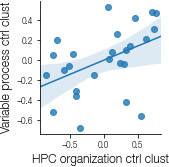

In [29]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
resid = df.copy()
res = smf.ols(formula='v_vec_lhpc ~ vec_lhpc', data=df).fit()
resid.loc[:, 'vec_ctrl_sim'] = res.resid
res = smf.ols(formula='v1 ~ vec_lhpc', data=df).fit()
resid.loc[:, 'v1_ctrl_sim'] = res.resid
h = sns.regplot('v1_ctrl_sim', 'vec_ctrl_sim', data=resid)
h = ax.set_ylabel('Variable process ctrl clust')
h = ax.set_xlabel('HPC organization ctrl clust')
fig.savefig(os.path.join(model_dir, 'lba_nav_sim_vec_hpc_v1.pdf'))
rho, pv = st.spearmanr(resid['vec_ctrl_sim'], resid['v1_ctrl_sim'])
print(f'r={rho:.4f}, p={pv/2:.4f}')

### LPC item type and v2

r=0.3819, p=0.0271


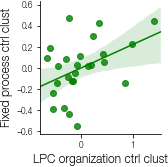

In [31]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
resid = df.copy()
res = smf.ols(formula='v_vec_llpc ~ vec_llpc', data=df).fit()
resid.loc[:, 'vec_ctrl_sim'] = res.resid
res = smf.ols(formula='v3 ~ vec_llpc', data=df).fit()
resid.loc[:, 'v3_ctrl_sim'] = res.resid
h = sns.regplot('v3_ctrl_sim', 'vec_ctrl_sim', data=resid, color='g')
h = ax.set_ylabel('Fixed process ctrl clust')
h = ax.set_xlabel('LPC organization ctrl clust')
fig.savefig(os.path.join(model_dir, 'lba_nav_sim_vec_lpc_v3.pdf'))
rho, pv = st.spearmanr(resid['vec_ctrl_sim'], resid['v3_ctrl_sim'])
print(f'r={rho:.4f}, p={pv/2:.4f}')

### PHC item type and v3

r=0.3456, p=0.0419


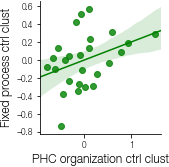

In [33]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
resid = df.copy()
res = smf.ols(formula='v_vec_lphc ~ vec_lphc', data=df).fit()
resid.loc[:, 'vec_ctrl_sim'] = res.resid
res = smf.ols(formula='v3 ~ vec_lphc', data=df).fit()
resid.loc[:, 'v3_ctrl_sim'] = res.resid
h = sns.regplot('v3_ctrl_sim', 'vec_ctrl_sim', data=resid, color='g')
h = ax.set_ylabel('Fixed process ctrl clust')
h = ax.set_xlabel('PHC organization ctrl clust')
fig.savefig(os.path.join(model_dir, 'lba_nav_sim_vec_phc_v3.pdf'))
rho, pv = st.spearmanr(resid['vec_ctrl_sim'], resid['v3_ctrl_sim'])
print(f'r={rho:.4f}, p={pv/2:.4f}')